# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization

 * Deep Learning for Computer Vision – Winter Term 2024/25
 * Lecture by: Constantin Pape
 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
 * Due date: **Tuesday, Nov 5, before 10:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`

## Introduction

In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
- [PyTorch tutorial](https://pytorch.org/tutorials/)
- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [1]:
import os
import time
import pathlib
import fastprogress

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### GPU and CUDA checks

Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the bottom-right corner menu `<` -> `Notebook options` -> `Accelerator` -> Select `GPU P100` as Hardware accelerator.

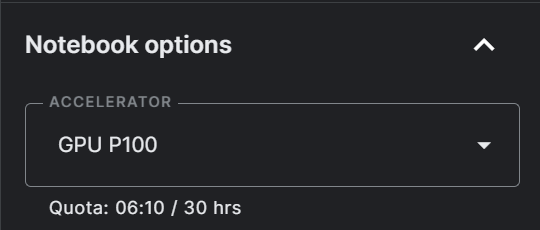

Now check the availability again (you would have to re-run the imports)

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

In [4]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print(
        'cuda available:', torch.cuda.is_available(), 
        '; cudnn available:', torch.backends.cudnn.is_available(),
        '; num devices:', torch.cuda.device_count()
    )
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [5]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
4 CPUs available


## Deep Learning with PyTorch

The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The model fitting is split into training and evaluation. In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction. The loss compares the prediction with the ground truth. In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the evaluation process the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.

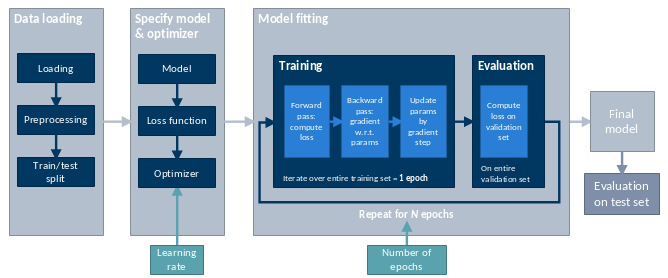

## Data Loading

## CIFAR dataset

This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.

**Download** the CIFAR dataset using torchvision dataset classes.

In [6]:
# DO NOT CHANGE
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

100%|██████████| 170498071/170498071 [00:16<00:00, 10177850.05it/s]


Extracting data/cifar-10-python.tar.gz to data


Let's check the first sample to see what it looks like

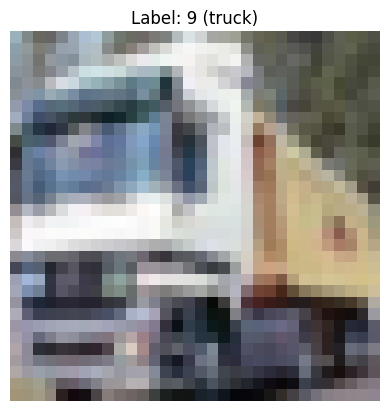

In [7]:
X_sample, y_sample = cifar[1]
# TODO: display the label and the image
plt.imshow(X_sample)
plt.title(f"Label: {y_sample} ({cifar.classes[y_sample]})")
plt.axis("off")
plt.show()

Look at the types of X and y.

In [8]:
# TODO: display types
print(f"Type of X_sample (image): {type(X_sample)}")
print(f"Type of y_sample (label): {type(y_sample)}")

Type of X_sample (image): <class 'PIL.Image.Image'>
Type of y_sample (label): <class 'int'>


How many data points are there in the dataset?

In [9]:
# TODO: print out the length of the dataset
print(f"Length of the CIFAR-10 dataset: {len(cifar)}")

Length of the CIFAR-10 dataset: 50000


## Loading data

### Preprocessing the Data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to transform _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

#### Normalization

Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance.

See https://pytorch.org/vision/stable/transforms.html for more information.

We can combine multiple transformations via _transforms.Compose_.

In [10]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

#### Training, Validation and Test Sets

For the correct ftting of a neural network, we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.

Note that you should not use the test set in any part of your training and model selection procedure. It should only be used for showing the final results.

We first need to **load** the datasets (above we did that already to calculate the normalization values. Then, we load them and **apply the normalization transform**)

We also need to **split** the train dataset into two sets, one for training and one for validation. While the training set needs to be quite large, the validation set can be relatively small. Take 10% of the dataset as validation set. Assign samples _randomly_ to the training and validation set, using a fixed seed to ensure reproducibility.

In [11]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(
        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)
    )
    return trainset, valset

To load the data for model training, we need to define **dataloaders**. A dataloader represents a Python iterable over a dataset and draws mini batches with random samples. Obseve below that we have a default number for batch size, and we shuffle the samples in batches.

In [12]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )

    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [13]:
####################
## YOUR CODE HERE ##
####################

trainset, testset, dataset_mean, dataset_std = grab_data(data_dir)

trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)

batch_size = 1024
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all the class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [14]:
def imshow(img, mean, std):
    """Undo normalization using mean and standard deviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    img = img.clone()
    img = img.permute(1, 2, 0)
    img = img * std + mean
    img = img.numpy()
    plt.imshow(img)

All class names are : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


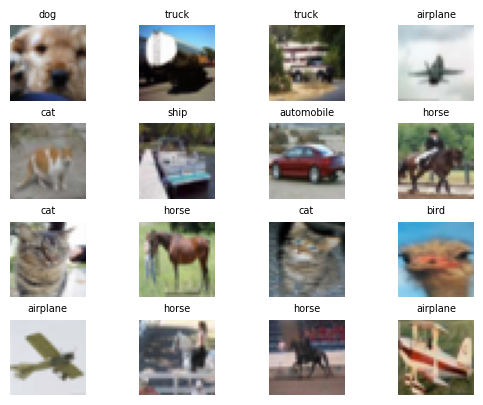

In [15]:
# Create actual plot and print the class names



####################

## YOUR CODE HERE ##

all_labels = trainset.dataset.classes
print('All class names are :', all_labels)
dataiter = iter(trainloader)
images, labels = next(dataiter)
fig, axs = plt.subplots(4, 4)
for i in range(16):
    ax = axs[i // 4, i % 4]
    plt.sca(ax)  # Set the current axis to the subplot at position [i // 4, i % 4]
    imshow(images[i], dataset_mean, dataset_std)
    ax.set_title(all_labels[labels[i].item()], fontsize=7)
    ax.axis('off') 
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

####################



# Hint: Use `torchvision.utils.make_grid`.

Now that you know what CIFAR10 looks like, you can guess what the task for this dataset is: classification in natural images

## Training, evaluation and plotting functions

Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [16]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False
):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar
        )
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar
        )

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                print("Early stopping triggered.")
                break

            #raise NotImplementedError # Comment out this keyword after your implementation

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(
    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None
):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        plt.plot(extra_pt[0], extra_pt[1], 'ko', label=extra_pt_label or 'Extra Point')
        #raise NotImplementedError # Comment out this keyword after your implementation

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [53]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(
        self, img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=None
    ):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        super(MLP, self).__init__()
        
        self.act_fn = act_fn if act_fn is not None else nn.ReLU()

        self.input_size = img_width * img_width * num_in_channels
        self.flatten = nn.Flatten()

        layers = [self.flatten]
        
        if isinstance(num_hidden_units, int):
            hidden_units = [num_hidden_units] * num_hidden_layers
        elif isinstance(num_hidden_units, list) and len(num_hidden_units) == num_hidden_layers:
            hidden_units = num_hidden_units
        else:
            raise ValueError("num_hidden_units should be an int or a list of length equal to num_hidden_layers")
            
        layers.append(nn.Linear(self.input_size, hidden_units[0]))
        layers.append(self.act_fn)

        for i in range(1, num_hidden_layers):
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(self.act_fn)

        # Output layer
        layers.append(nn.Linear(hidden_units[-1], num_classes))
        print(layers)
        # Register layers as a ModuleList or Sequential module
        self.network = nn.Sequential(*layers)
        

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        return self.network(x)

## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.

#### TODO:
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

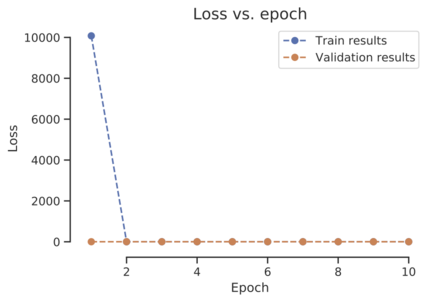

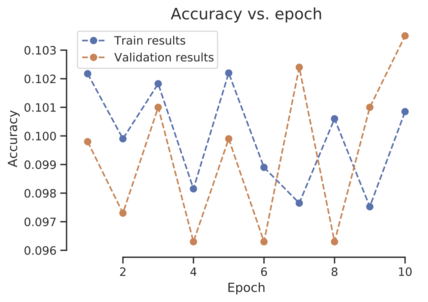

The Accuracy vs. Epoch plot shows both training and validation accuracies fluctuating around a low value without any upward trend. This behavior suggests that the model isn’t improving its performance with more epochs, which is typically a sign of insufficient learning, a poor learning rate, or that the model is too simple for the dataset. Normally, if a model is underfitting or overfitting, you would see a distinct difference between training and validation metrics over time. Here, both training and validation results stay close, implying that the model is consistently failing to learn from both training and validation data.

**This is an example of a model that does train:** *(Why?)*

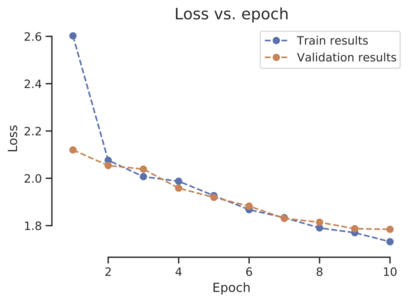

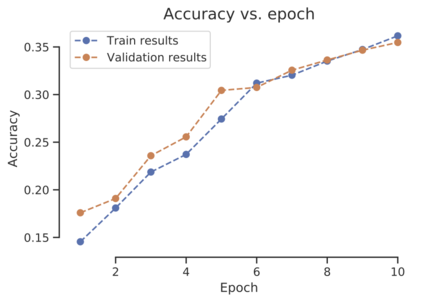

In the Loss vs. Epoch plot, both training and validation losses steadily decrease as epochs progress. This downward trend indicates that the model is learning from the data, as the loss consistently decreases with more training. The fact that training and validation loss and accuracy are closely aligned implies that the model has a balanced learning process. If the validation metrics diverged significantly from the training metrics, it could indicate overfitting or underfitting issues.

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 115 seconds.
------------------------------------------ Learning rate : 1 ------------------------------------------
Best Validation Accuracy : 0.1035 with Train Accuracy : 0.100575 at Epoch Number : 2
Best Validation Loss : 2.311294674873352 with Train Loss : 2.3154304563999175 at Epoch Number : 5


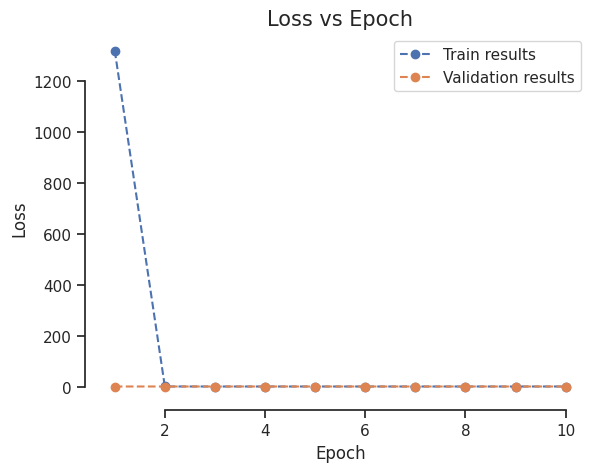

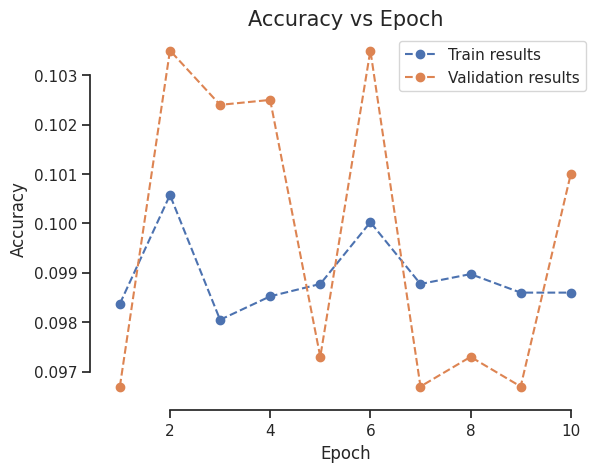

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 115 seconds.
------------------------------------------ Learning rate : 0.1 ------------------------------------------
Best Validation Accuracy : 0.1025 with Train Accuracy : 0.098975 at Epoch Number : 8
Best Validation Loss : 2.302823042869568 with Train Loss : 2.3038190603256226 at Epoch Number : 9


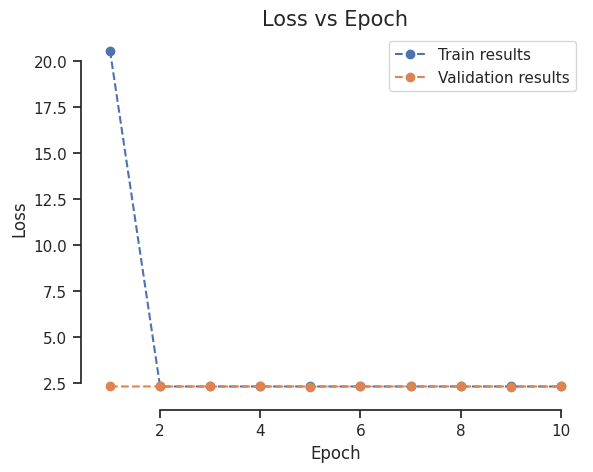

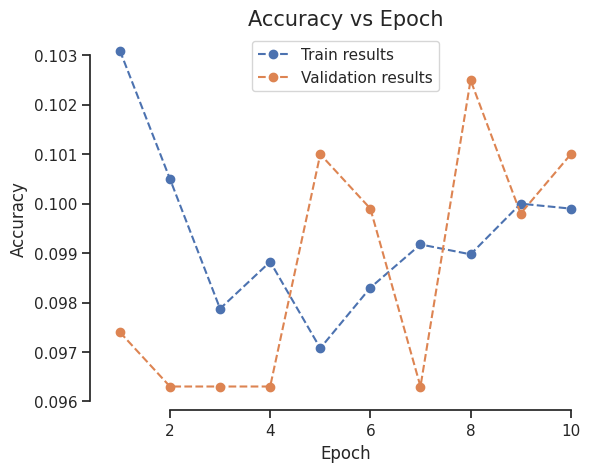

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 115 seconds.
------------------------------------------ Learning rate : 0.01 ------------------------------------------
Best Validation Accuracy : 0.4491 with Train Accuracy : 0.453525 at Epoch Number : 9
Best Validation Loss : 1.569600474834442 with Train Loss : 1.518499419093132 at Epoch Number : 9


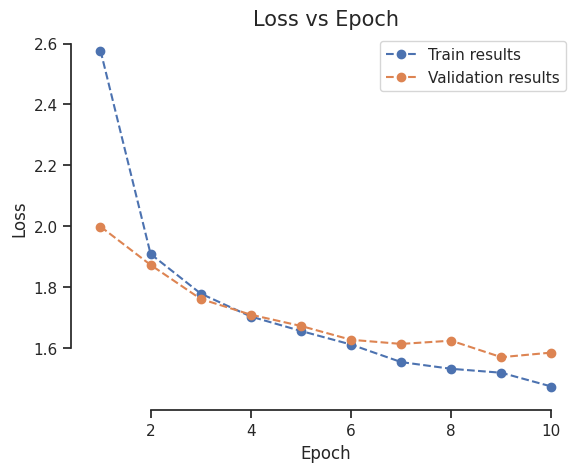

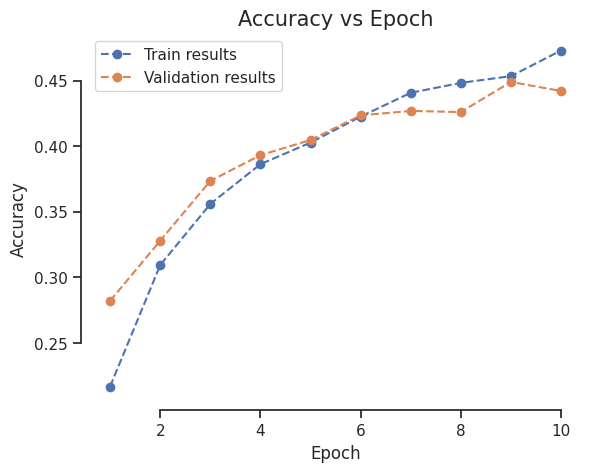

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 115 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.4521 with Train Accuracy : 0.492175 at Epoch Number : 9
Best Validation Loss : 1.5702314019203185 with Train Loss : 1.445738485455513 at Epoch Number : 9


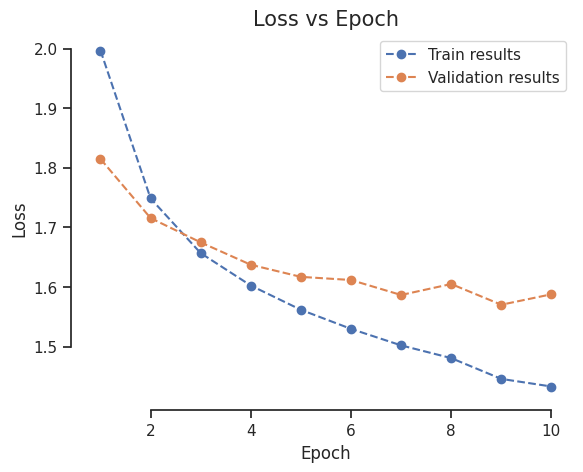

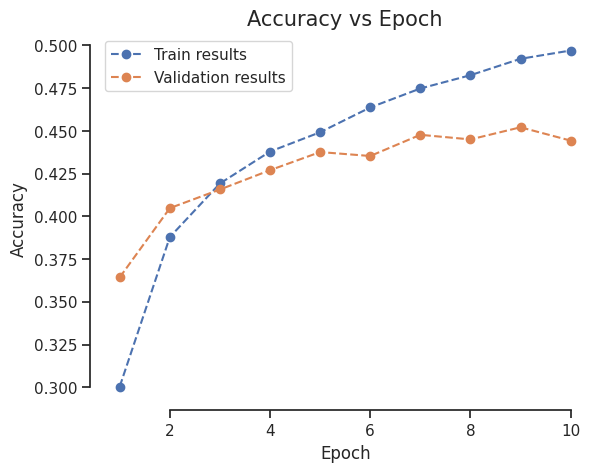

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 114 seconds.
------------------------------------------ Learning rate : 0.0001 ------------------------------------------
Best Validation Accuracy : 0.3965 with Train Accuracy : 0.4041 at Epoch Number : 10
Best Validation Loss : 1.739673125743866 with Train Loss : 1.7202216565608979 at Epoch Number : 10


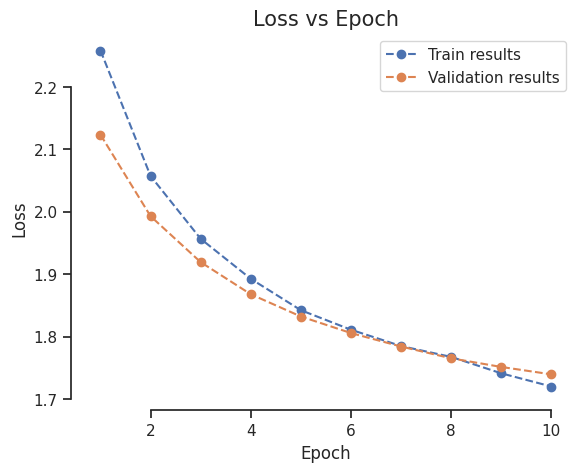

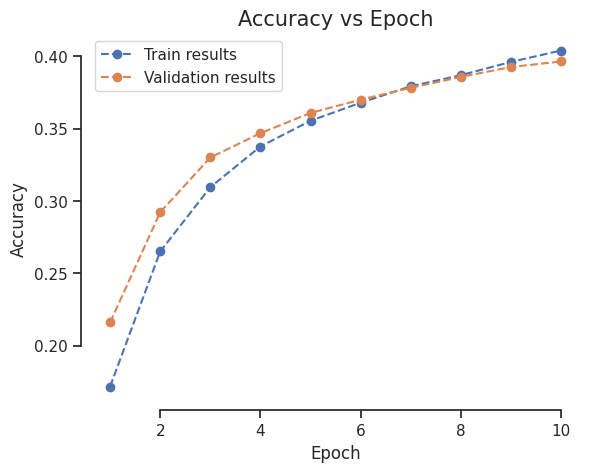

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 114 seconds.
------------------------------------------ Learning rate : 1e-05 ------------------------------------------
Best Validation Accuracy : 0.2447 with Train Accuracy : 0.230275 at Epoch Number : 10
Best Validation Loss : 2.1130356073379515 with Train Loss : 2.120430624485016 at Epoch Number : 10


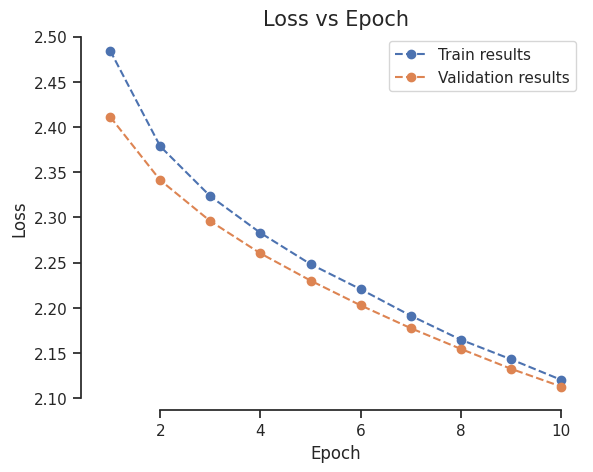

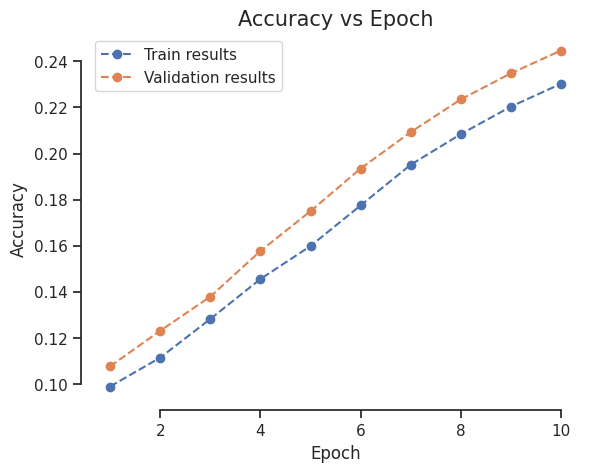

In [29]:
####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()

for i in range(6):
    learning_rate = 10 ** (-i)
    
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate} ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Finished training after 1149 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.473 with Train Accuracy : 0.59915 at Epoch Number : 47
Best Validation Loss : 1.526354146003723 with Train Loss : 1.327895388007164 at Epoch Number : 18


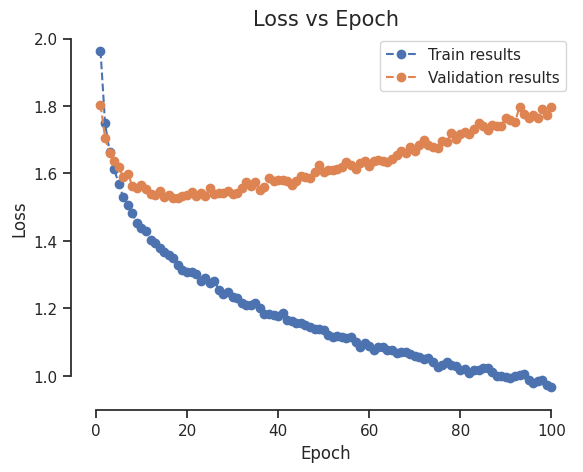

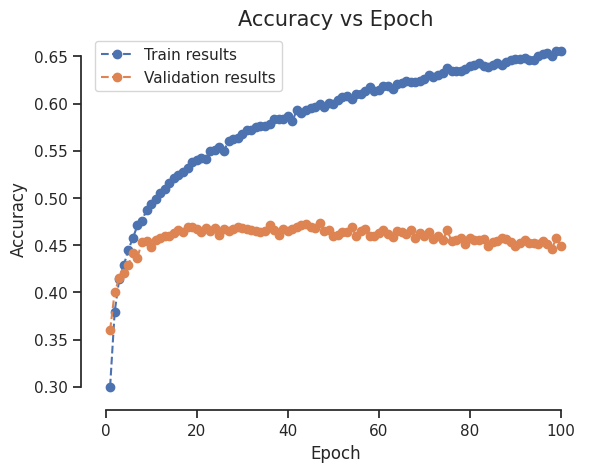

In [30]:
####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

learning_rate = 10 ** (-3)
    
model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
model.to(device)
    
model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_fn, device, num_epochs, trainloader, valloader
)
    
print(f'------------------------------------------ Learning rate : {learning_rate} ------------------------------------------')
best_val_acc_index = np.argmax(val_accs)
print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
best_val_loss_index = np.argmin(val_losses)
print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

Let's have a look at those training curves! Here are some questions for you.

#### TODO:
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. Yes, the training loss decreases after each epoch. This happens because the optimizer continuously adjusts the model’s weights to minimize the training loss. During each epoch, the backpropagation process updates the weights to reduce prediction errors for the training data. Over time, this process allows the model to improve its predictions on the training set, which results in a gradual reduction in training loss.

2. No, the validation loss does not consistently decrease after each epoch. Unlike the training loss, the validation loss may fluctuate because the validation set is not used for direct optimization. As the model becomes more tailored to the training data, it may start to "memorize" specific patterns that don’t generalize well to new data, causing fluctuations in the validation loss. In our case, the validation loss initially decreases but then begins to increase at certain points, indicating that the model may be starting to overfit. This pattern shows that the validation loss curve reaches a minimum before increasing, suggesting that there’s an optimal point after which further training does not improve validation performance.

3. The training accuracy generally increases after each epoch because the model is improving its ability to predict training samples accurately as it learns from them. However, the validation accuracy does not always increase and may fluctuate due to variations in the model’s generalization performance. The optimizer adjusts the weights to minimize training errors, which typically improves training accuracy. For the validation set, accuracy may fluctuate because the model encounters data it hasn’t seen before, and it may not perform consistently well on these samples if it overfits the training set.

4. No, the epochs with the best validation loss and the best validation accuracy are not the same. In this example, the best validation loss occurs at epoch 18, while the best validation accuracy occurs at epoch 47.

5. This difference occurs because loss and accuracy measure different aspects of model performance. Loss measures the confidence of the model’s predictions, considering how close the predicted probabilities are to the actual labels. Accuracy, on the other hand, is a simpler metric that only counts the percentage of correct predictions. It’s possible for a model to make correct predictions (high accuracy) while having lower confidence (higher loss), resulting in a higher accuracy at a different epoch than the lowest loss.

6. The model was best at epoch 18, where it achieved the lowest validation loss. This point represents the optimal balance between training on the dataset and generalizing to unseen data, as it indicates minimal overfitting. Using the model at this epoch to make predictions on new samples would likely yield the best generalization performance. If training continued beyond this point, the model’s performance on the validation set could degrade, meaning it would overfit by capturing noise in the training data instead of useful patterns.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO:
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [31]:
####################
## YOUR CODE HERE ##
####################
torch.save(model.state_dict(), '/kaggle/working/model1_checkpoint.pth')
# Feel free to add more cells here.

In [35]:
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

model2 = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
model2.to(device)

_, val_accuracy_untrained, _ = validate(valloader, model2, loss, device, master_bar = None)
print(f'Validation accuracy for model2 before loading model one parameters is : {val_accuracy_untrained}')
model2.load_state_dict(torch.load('model1_checkpoint.pth'))
_, val_accuracy_pretrained, _ = validate(valloader, model2, loss, device, master_bar = None)
print(f'Validation accuracy for model2 after loading model one parameters is : {val_accuracy_pretrained}')

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Validation accuracy for model2 before loading model one parameters is : 0.094


/tmp/ipykernel_30/1391991644.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model1_checkpoint.pth'))


Validation accuracy for model2 after loading model one parameters is : 0.4495


## Early Stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [36]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.best_accuracy = 0
        self.counter = 0
        self._early_stop = False
        
    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        return self._early_stop

    def update(self, val_acc, model):
        """Call after each epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        if val_acc > self.best_accuracy:
            self.best_accuracy = val_acc
            self.counter = 0
            self.save_checkpoint(model, val_acc)
            if self.verbose:
                print(f"Validation accuracy improved to {val_acc:.4f}. Saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation accuracy for {self.counter} epoch(s).")

            if self.counter >= self.patience:
                self._early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Model checkpoint saved at '{self.path}' with accuracy {val_acc:.4f}.")

    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        model.load_state_dict(torch.load(self.path))
        if self.verbose:
            print(f"Model checkpoint loaded from '{self.path}'.")
        return model

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 92 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.4417 with Train Accuracy : 0.472525 at Epoch Number : 7
Best Validation Loss : 1.5845072746276856 with Train Loss : 1.5070315033197403 at Epoch Number : 7


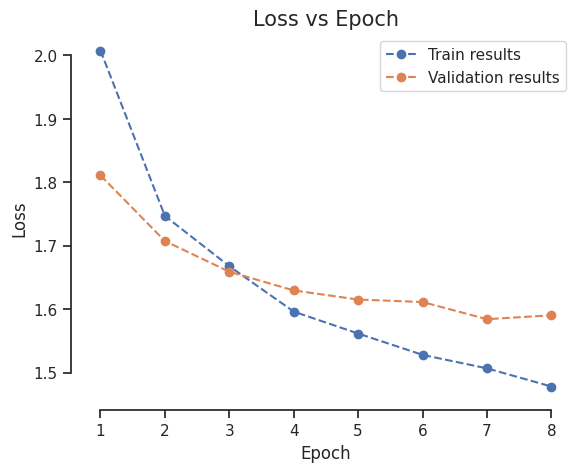

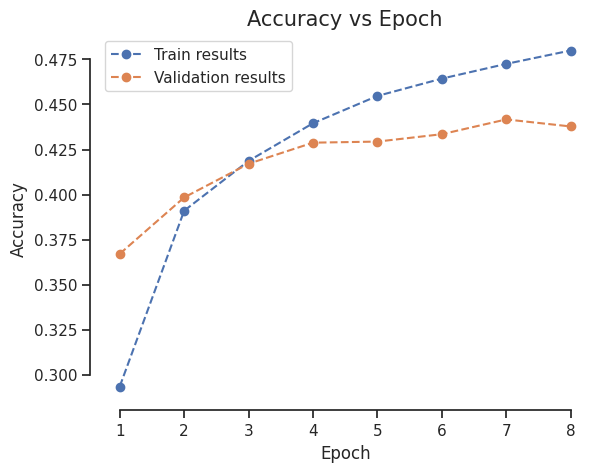

In [38]:
####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(path = 'early_stoper_checkpoint.pt', patience=1)

learning_rate = 10 ** (-3)
    
model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
model.to(device)
    
model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
    model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
)
    
print(f'------------------------------------------ Learning rate : {learning_rate} ------------------------------------------')
best_val_acc_index = np.argmax(val_accs)
print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
best_val_loss_index = np.argmin(val_losses)
print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

#### TODO:
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

1. Comparing the training done with early stopping to the training done for the full 100 epochs, I observed that the model with early stopping achieved its best performance within just 7 epochs. In contrast, when training for the full 100 epochs, the best model performance was achieved at 18 epochs. This suggests that with early stopping, the model converged faster and avoided unnecessary training that could lead to overfitting. Early stopping halted the training at an optimal point where the validation loss stopped improving, ensuring that the model didn’t start overfitting the training data. Although the early-stopped model did not achieve as low a loss or as high an accuracy as the model trained for 100 epochs, it is likely more generalizable and less prone to overfitting due to stopping before excessive training.
2. Yes, experimenting with different values for patience did allow the model to reach a high validation accuracy within fewer epochs compared to training for the full 100 epochs. By adjusting the patience parameter, the early stopping mechanism waited longer for potential improvements in validation accuracy before halting training, allowing the model to explore a better fit without running the full 100 epochs. However, while we achieved good validation accuracy with early stopping and fewer epochs, the validation accuracy was still slightly lower than the best result obtained from training the model for the full 100 epochs without early stopping. This suggests that while early stopping is beneficial in reducing training time and preventing overfitting, achieving the absolute peak validation accuracy may sometimes require a longer training duration.

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 206 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.4666 with Train Accuracy : 0.5225 at Epoch Number : 16
Best Validation Loss : 1.5342401266098022 with Train Loss : 1.3561892420053483 at Epoch Number : 16


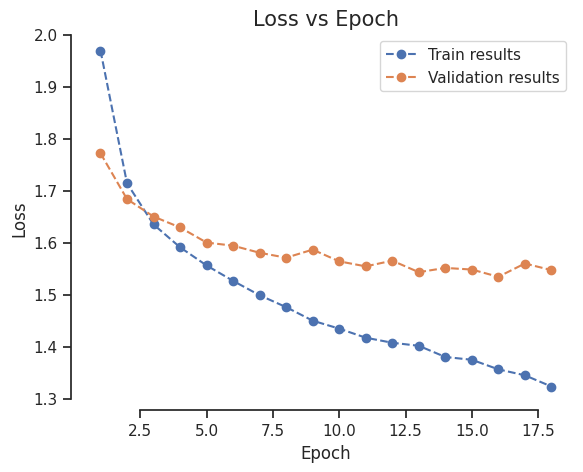

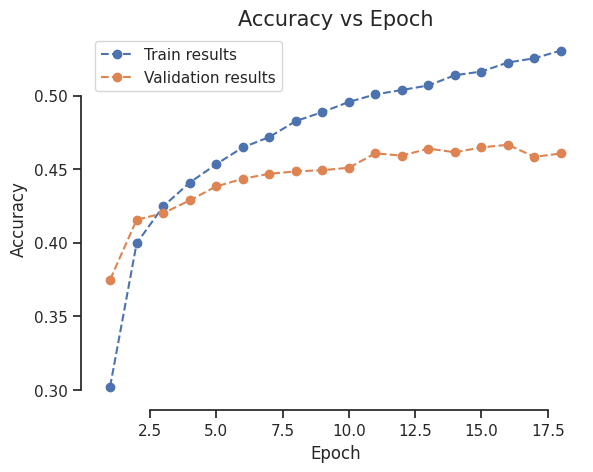

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 219 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.465 with Train Accuracy : 0.526675 at Epoch Number : 16
Best Validation Loss : 1.5540224671363831 with Train Loss : 1.3819820821285247 at Epoch Number : 14


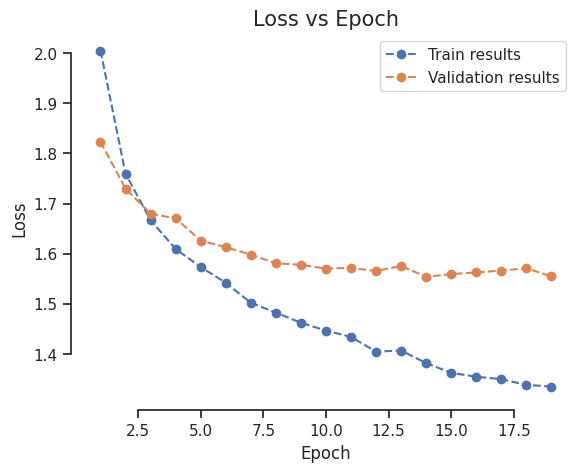

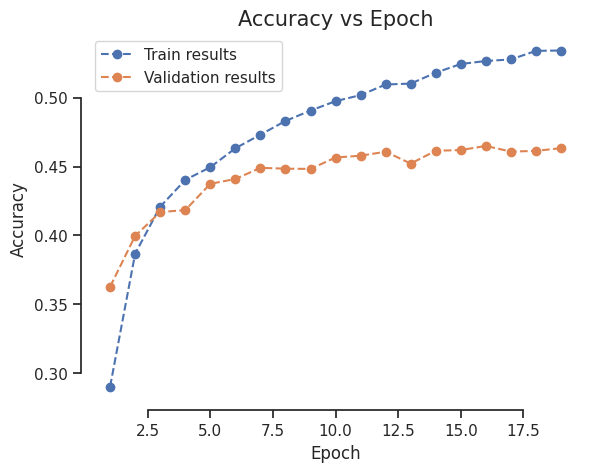

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 138 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.4544 with Train Accuracy : 0.48725 at Epoch Number : 8
Best Validation Loss : 1.5671529293060302 with Train Loss : 1.427465346455574 at Epoch Number : 10


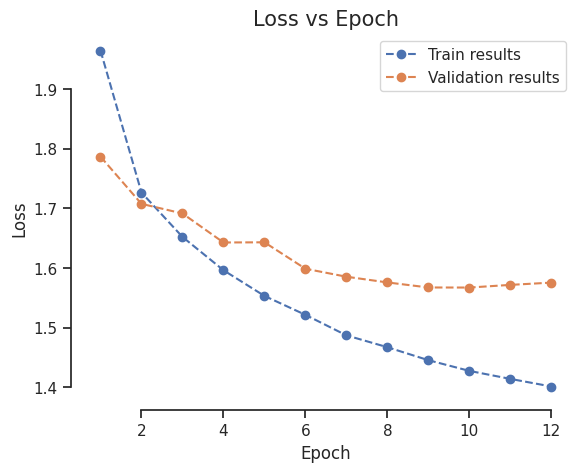

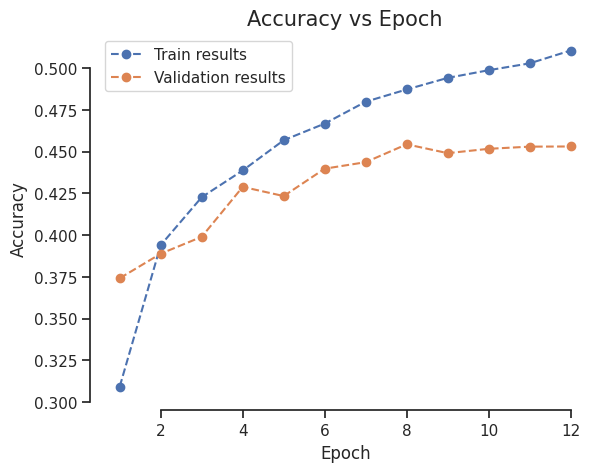

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 267 seconds.
------------------------------------------ Learning rate : 0.001 ------------------------------------------
Best Validation Accuracy : 0.4661 with Train Accuracy : 0.5283 at Epoch Number : 18
Best Validation Loss : 1.542244827747345 with Train Loss : 1.396374136209488 at Epoch Number : 13


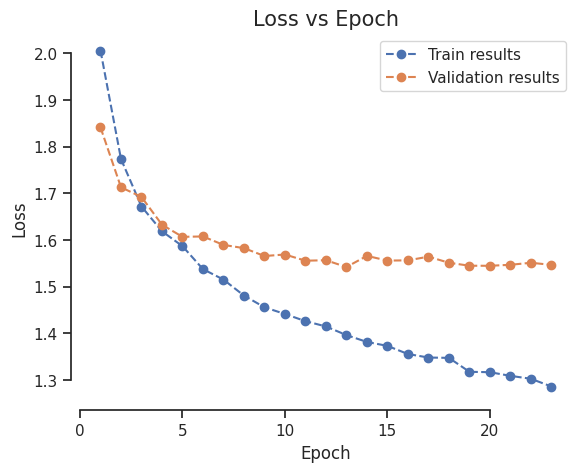

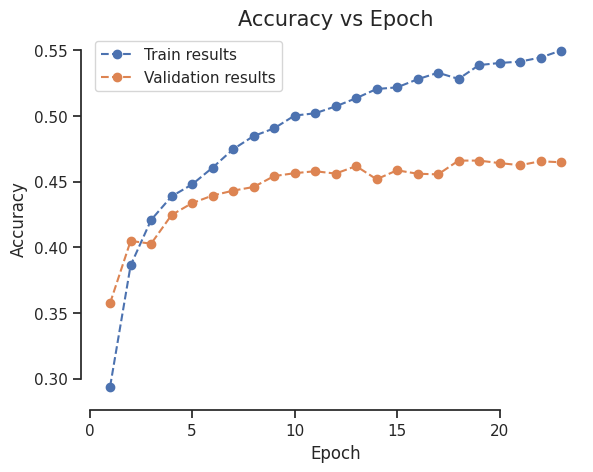

In [40]:
####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(path = 'early_stoper_checkpoint.pt', patience=1)

learning_rate = 10 ** (-3)

for i in range(2,6):
    early_stopper = EarlyStopper(path = f'early_stoper_patience{i}_checkpoint.pt', patience=i)
    
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : {i} ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

From the experiments, it was observed that a lower learning rate resulted in more stable training with smoother training and validation loss curves. This stability indicates that the model is learning more gradually, which can reduce fluctuations in accuracy and minimize the risk of overshooting the optimal point. With a lower learning rate, however, the training took longer, as more epochs were required to reach convergence.

In contrast, a higher learning rate allowed the model to reach higher accuracy more quickly, with fewer epochs, but this also introduced greater fluctuations in the loss and accuracy curves. Additionally, the higher learning rate increased the risk of overfitting, as the model could start "overshooting" optimal solutions, causing it to fit the training data more closely than the validation data.

Considering these trade-offs, a learning rate of 10**(-3) appears to be a balanced choice for subsequent experiments. This learning rate offers a good balance between speed and stability, allowing the model to converge in fewer epochs while maintaining relatively stable accuracy and loss without significant overfitting.

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 103 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 2 ------------------------------------------
Best Validation Accuracy : 0.449 with Train Accuracy : 0.4755 at Epoch Number : 7
Best Validation Loss : 1.5816201448440552 with Train Loss : 1.502567434310913 at Epoch Number : 7


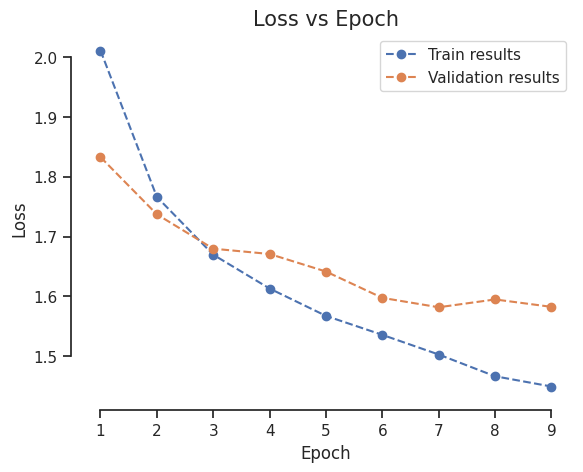

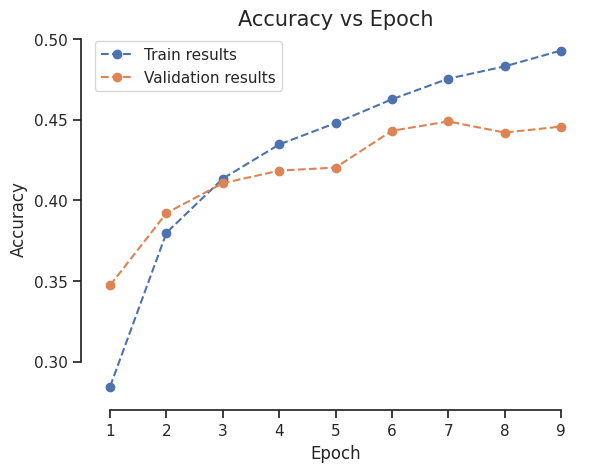

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 332 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 3 ------------------------------------------
Best Validation Accuracy : 0.4731 with Train Accuracy : 0.562675 at Epoch Number : 26
Best Validation Loss : 1.527479898929596 with Train Loss : 1.2891709208488464 at Epoch Number : 23


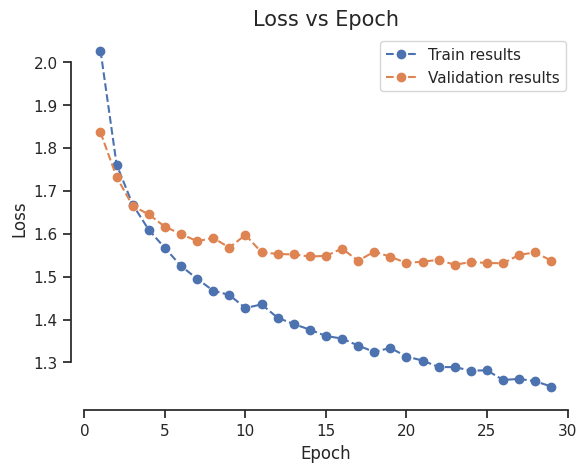

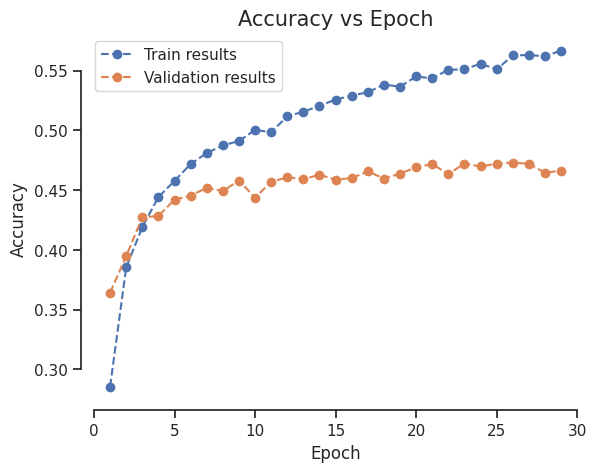

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 288 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4 ------------------------------------------
Best Validation Accuracy : 0.4737 with Train Accuracy : 0.54715 at Epoch Number : 21
Best Validation Loss : 1.5202221274375916 with Train Loss : 1.2872196078300475 at Epoch Number : 21


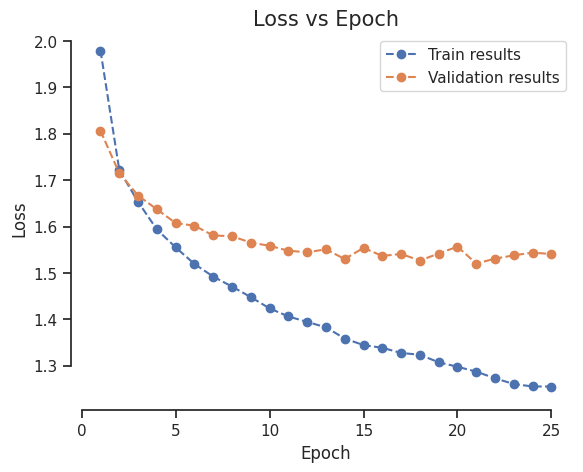

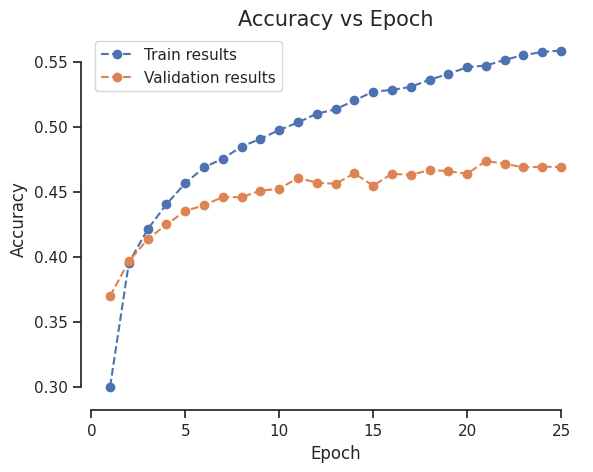

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 244 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 5 ------------------------------------------
Best Validation Accuracy : 0.4722 with Train Accuracy : 0.5234 at Epoch Number : 16
Best Validation Loss : 1.548415470123291 with Train Loss : 1.3608581930398942 at Epoch Number : 17


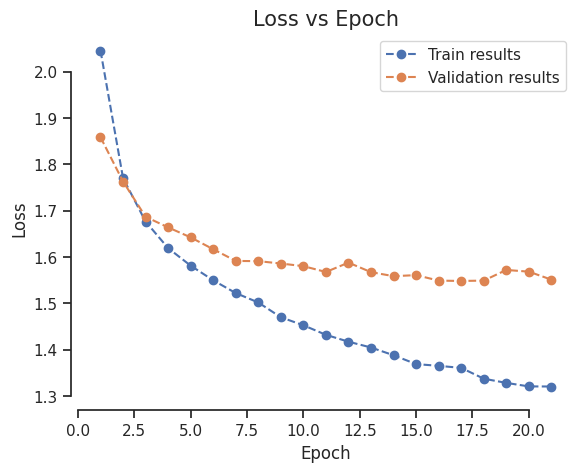

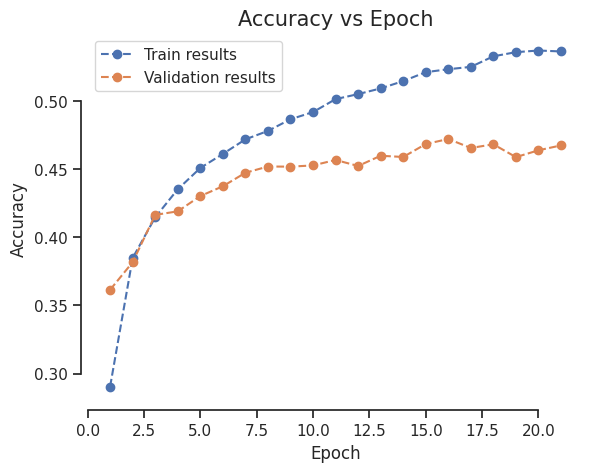

In [41]:
lr = 1e-3

####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(path = 'early_stoper_checkpoint.pt', patience=1)

learning_rate = 10 ** (-3)

for i in range(2,6):
    early_stopper = EarlyStopper(path = f'early_stoper_patience{i}_checkpoint.pt', patience=i)
    
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : {i} ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 378 seconds.
------------------------------------------ Learning rate : 0.0001, Patience : 2 ------------------------------------------
Best Validation Accuracy : 0.4546 with Train Accuracy : 0.486725 at Epoch Number : 31
Best Validation Loss : 1.5920982360839844 with Train Loss : 1.4889510780572892 at Epoch Number : 33


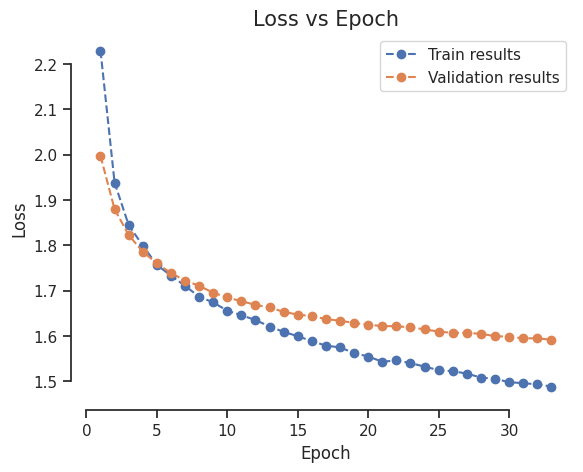

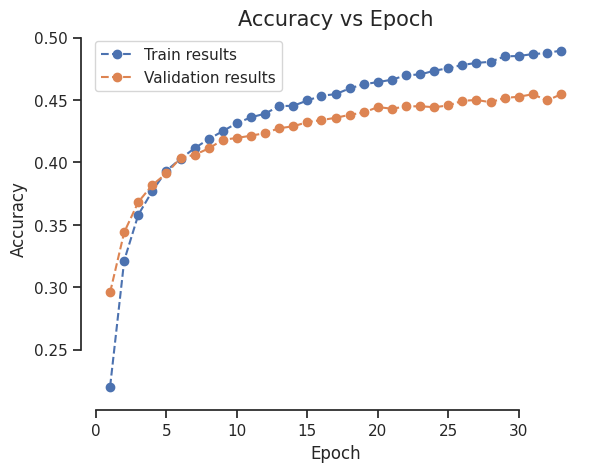

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 500 seconds.
------------------------------------------ Learning rate : 0.0001, Patience : 3 ------------------------------------------
Best Validation Accuracy : 0.4473 with Train Accuracy : 0.494075 at Epoch Number : 40
Best Validation Loss : 1.583756411075592 with Train Loss : 1.4580978602170944 at Epoch Number : 41


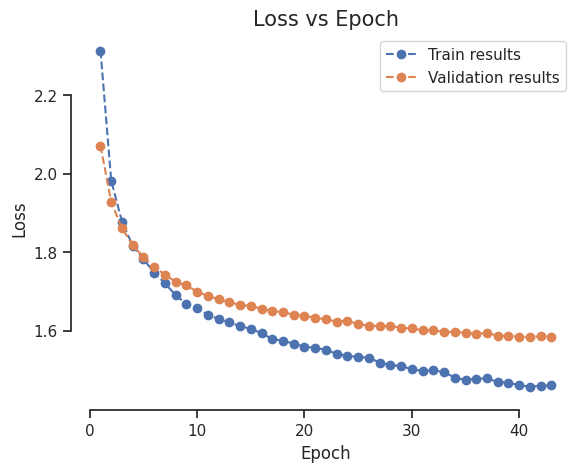

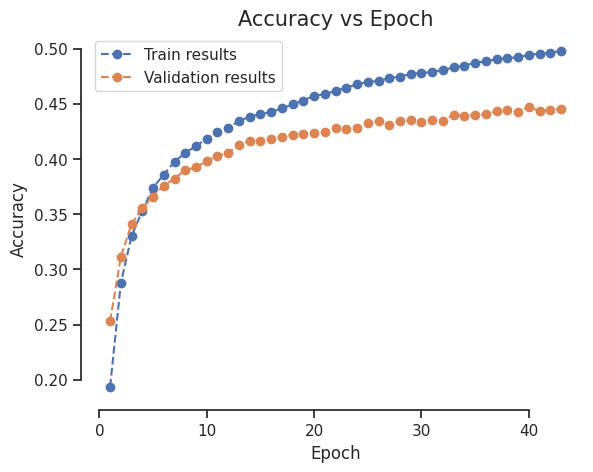

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 609 seconds.
------------------------------------------ Learning rate : 0.0001, Patience : 4 ------------------------------------------
Best Validation Accuracy : 0.4624 with Train Accuracy : 0.511475 at Epoch Number : 48
Best Validation Loss : 1.5589258909225463 with Train Loss : 1.4052306175231934 at Epoch Number : 52


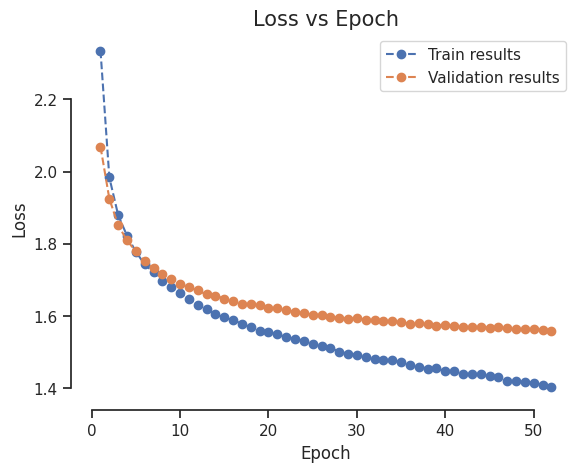

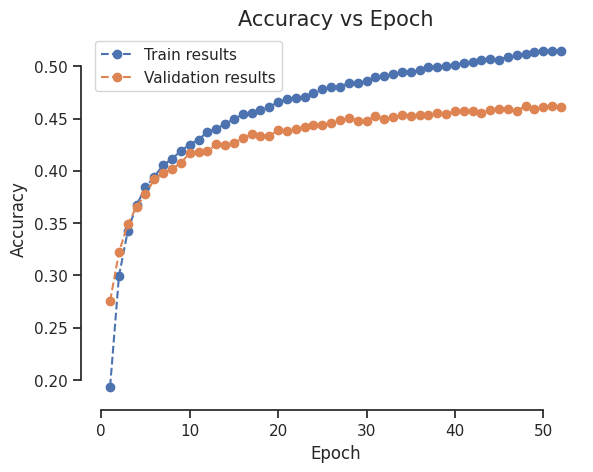

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 866 seconds.
------------------------------------------ Learning rate : 0.0001, Patience : 5 ------------------------------------------
Best Validation Accuracy : 0.4661 with Train Accuracy : 0.526025 at Epoch Number : 69
Best Validation Loss : 1.5549751400947571 with Train Loss : 1.3613816499710083 at Epoch Number : 74


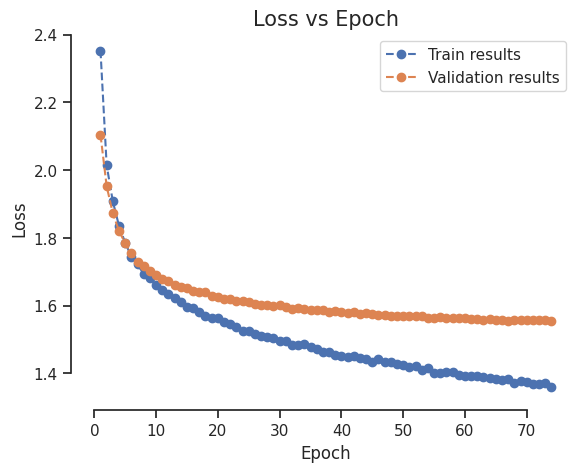

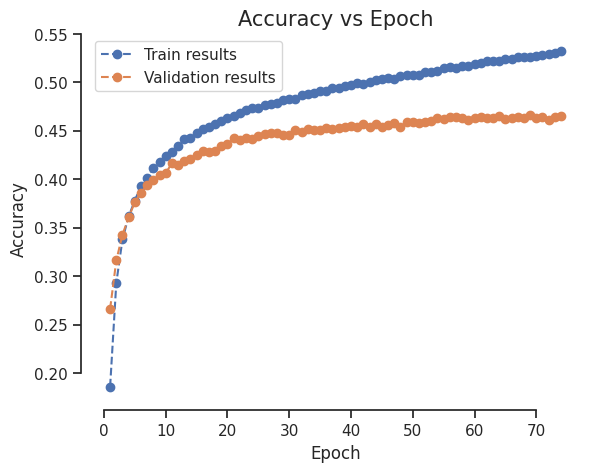

In [55]:
lr = 1e-4

####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(path = 'early_stoper_checkpoint.pt', patience=1)

learning_rate = 10 ** (-4)

for i in range(2,6):
    early_stopper = EarlyStopper(path = f'early_stoper_patience{i}_checkpoint.pt', patience=i)
    
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units, num_hidden_layers, act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : {i} ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

# What about the architecture?

How does architecture affect predictive performance?

Model architecture significantly impacts predictive performance by determining how well the model can capture patterns, generalize, and avoid overfitting. Depth and complexity allow deeper networks to learn intricate relationships, though they risk overfitting if too large. Layer types are chosen based on data structure. The number of parameters must balance learning capacity with generalization, while activation functions enable the model to capture non-linear relationships. Regularization techniques like dropout and batch normalization prevent overfitting, and advanced design choices such as residual connections and attention mechanisms improve training stability and performance on complex tasks. Together, these architectural choices optimize the model’s predictive accuracy and efficiency.

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3d8211d7e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3d8211d7e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Early stopping triggered.
Finished training after 238 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 30  ------------------------------------------
Best Validation Accuracy : 0.4652 with Train Accuracy : 0.525675 at Epoch Number : 16
Best Validation Loss : 1.5630741477012635 with Train Loss : 1.3441924452781677 at Epoch Number : 19


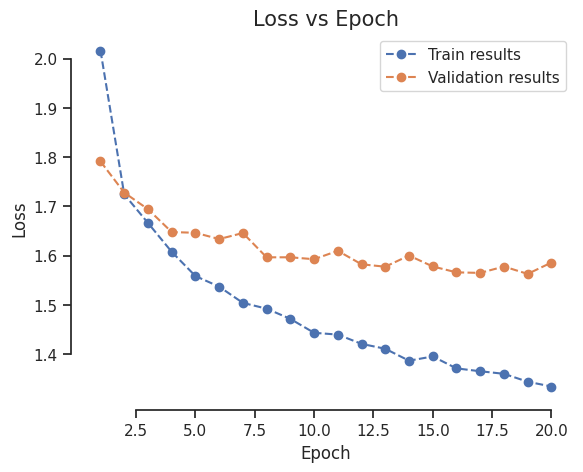

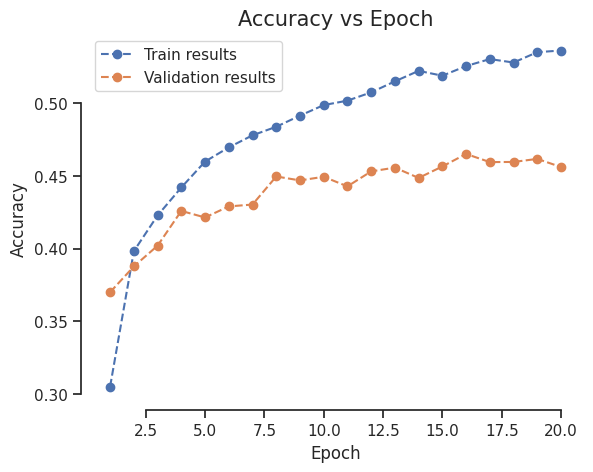

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=60, bias=True), ReLU(), Linear(in_features=60, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 156 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 60  ------------------------------------------
Best Validation Accuracy : 0.4712 with Train Accuracy : 0.546125 at Epoch Number : 9
Best Validation Loss : 1.5282816171646119 with Train Loss : 1.3518017262220383 at Epoch Number : 8


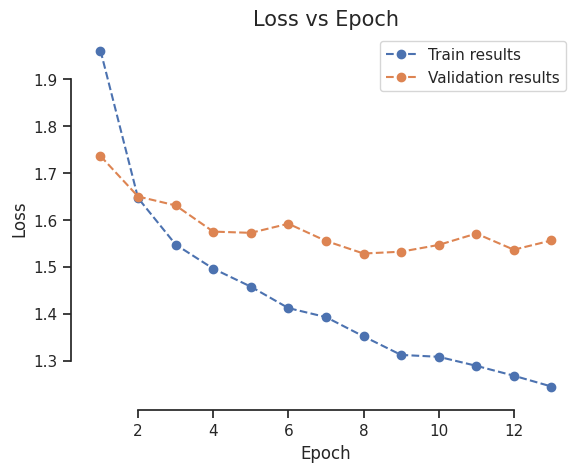

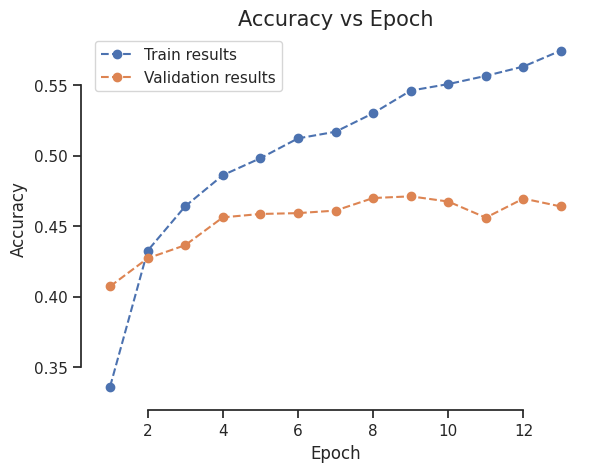

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=90, bias=True), ReLU(), Linear(in_features=90, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 221 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 90  ------------------------------------------
Best Validation Accuracy : 0.501 with Train Accuracy : 0.606675 at Epoch Number : 14
Best Validation Loss : 1.4903550505638123 with Train Loss : 1.1443823605775834 at Epoch Number : 14


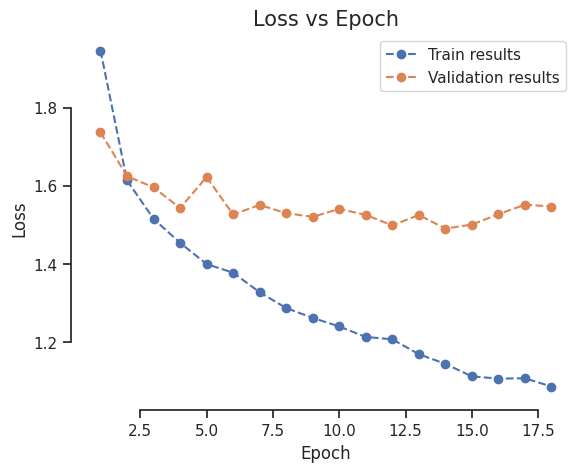

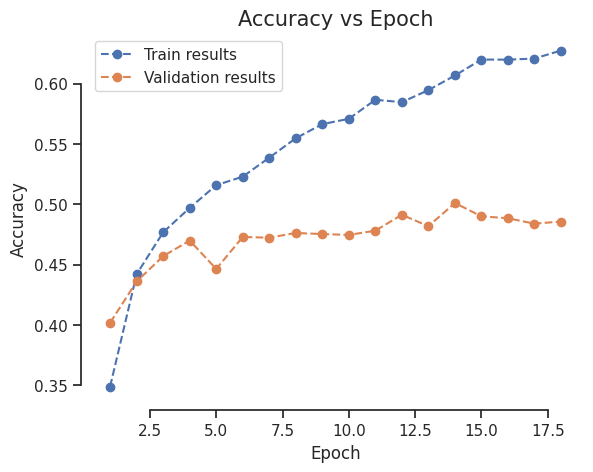

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=120, bias=True), ReLU(), Linear(in_features=120, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 149 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 120  ------------------------------------------
Best Validation Accuracy : 0.4961 with Train Accuracy : 0.57405 at Epoch Number : 8
Best Validation Loss : 1.4762636184692384 with Train Loss : 1.1846839129924773 at Epoch Number : 10


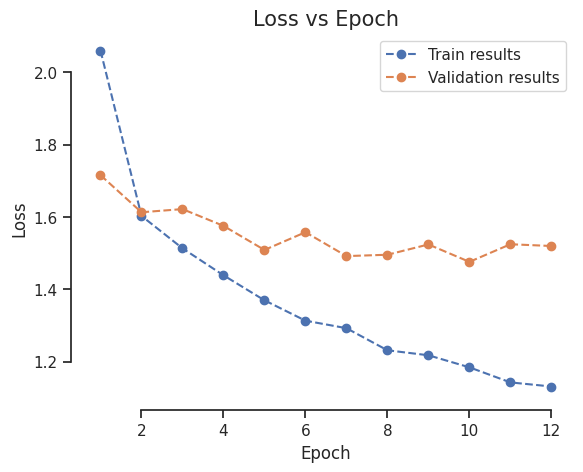

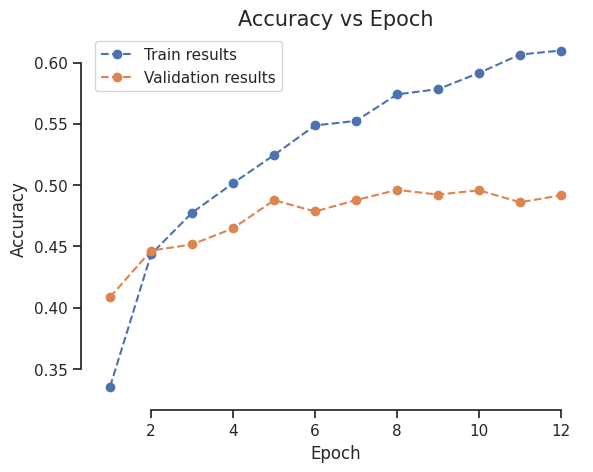

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=150, bias=True), ReLU(), Linear(in_features=150, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 259 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 150  ------------------------------------------
Best Validation Accuracy : 0.4998 with Train Accuracy : 0.6695 at Epoch Number : 17
Best Validation Loss : 1.4870911836624146 with Train Loss : 1.1312674075365066 at Epoch Number : 11


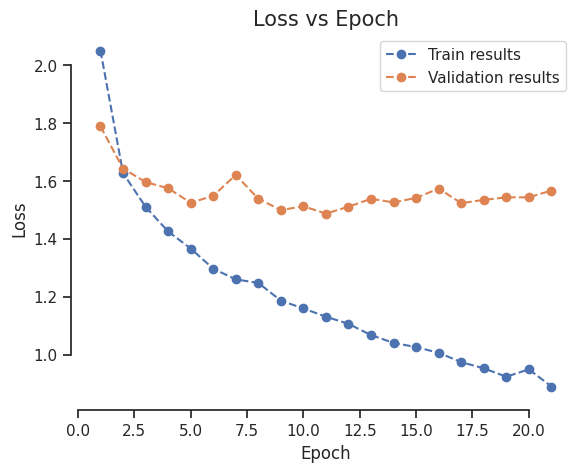

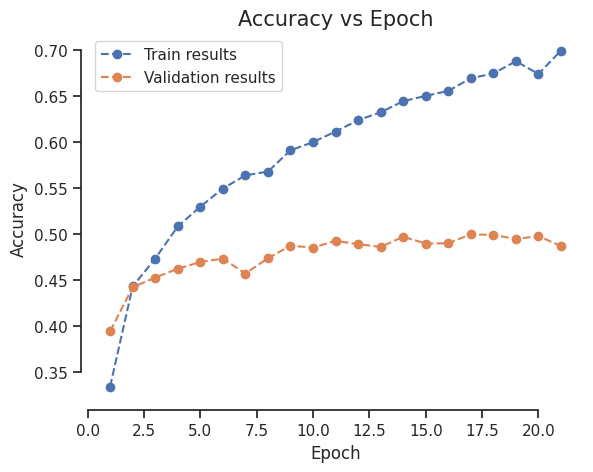

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=180, bias=True), ReLU(), Linear(in_features=180, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 222 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden units : 180  ------------------------------------------
Best Validation Accuracy : 0.5044 with Train Accuracy : 0.65395 at Epoch Number : 14
Best Validation Loss : 1.4818294405937196 with Train Loss : 1.0144699424505235 at Epoch Number : 14


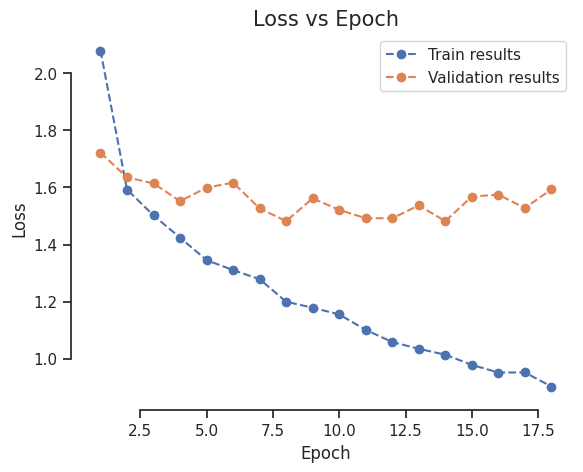

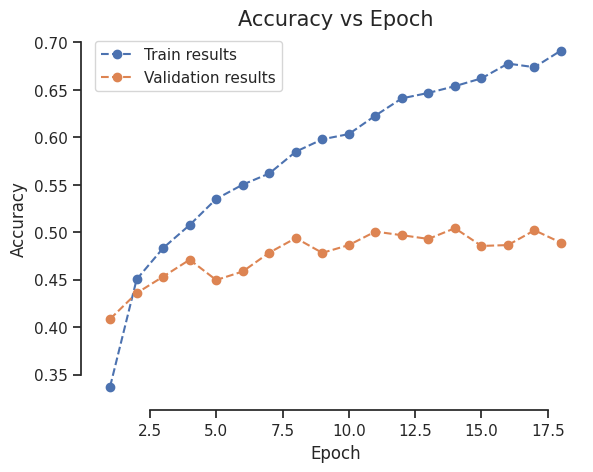

In [65]:
# number of hidden units

####################
## YOUR CODE HERE ##
####################
img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

learning_rate = 10 ** (-3)

for i in range(30, 210, 30):
    
    early_stopper = EarlyStopper(path = f'early_stoper_checkpoint_num_units{i}.pt', patience=4)
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=i, num_hidden_layers=1, act_fn=act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : 4, Number of hidden units : {i}  ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 243 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 1  ------------------------------------------
Best Validation Accuracy : 0.4584 with Train Accuracy : 0.529875 at Epoch Number : 17
Best Validation Loss : 1.5550294637680053 with Train Loss : 1.3484792560338974 at Epoch Number : 18


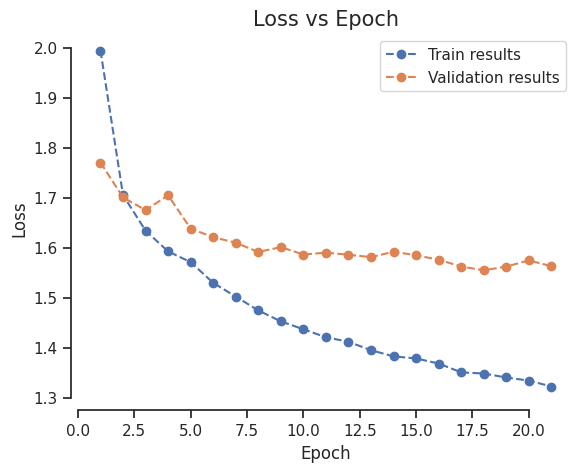

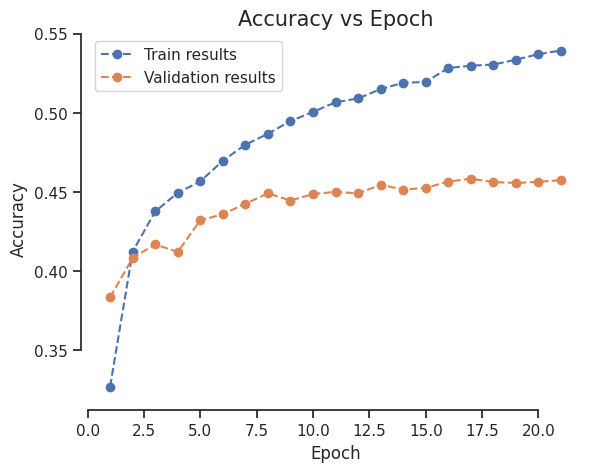

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 345 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 2  ------------------------------------------
Best Validation Accuracy : 0.4723 with Train Accuracy : 0.5535 at Epoch Number : 26
Best Validation Loss : 1.5323416113853454 with Train Loss : 1.2888727277517318 at Epoch Number : 25


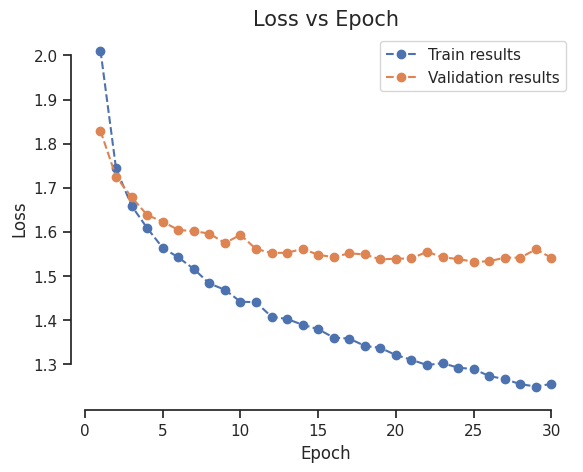

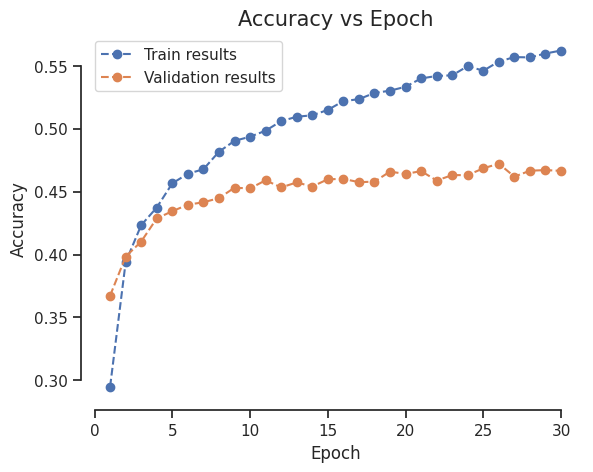

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 277 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 3  ------------------------------------------
Best Validation Accuracy : 0.4691 with Train Accuracy : 0.538175 at Epoch Number : 20
Best Validation Loss : 1.529048752784729 with Train Loss : 1.3041918009519577 at Epoch Number : 22


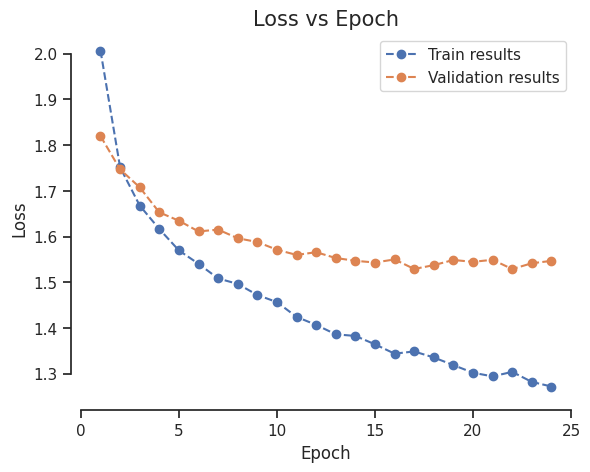

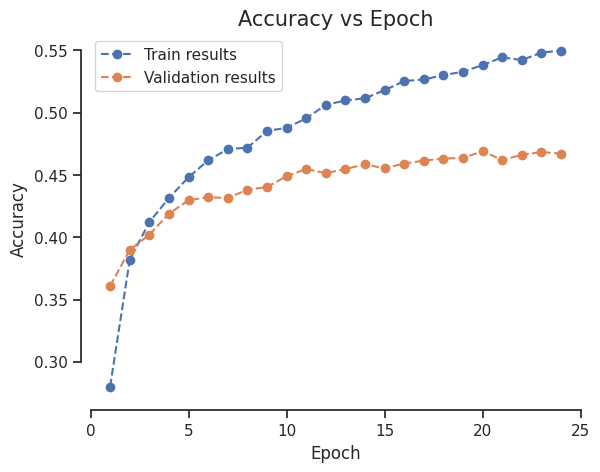

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 314 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 4  ------------------------------------------
Best Validation Accuracy : 0.4691 with Train Accuracy : 0.5437 at Epoch Number : 23
Best Validation Loss : 1.5316330313682556 with Train Loss : 1.2922150433063506 at Epoch Number : 23


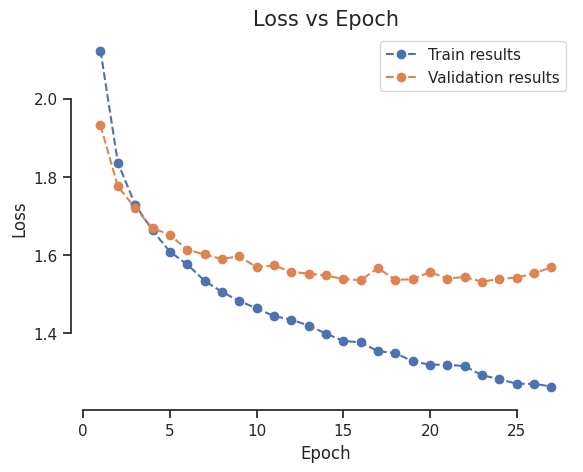

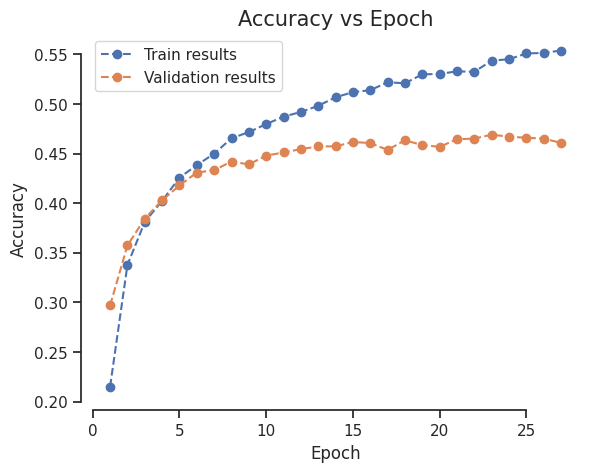

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 255 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 5  ------------------------------------------
Best Validation Accuracy : 0.4701 with Train Accuracy : 0.5358 at Epoch Number : 18
Best Validation Loss : 1.5250833630561829 with Train Loss : 1.322987374663353 at Epoch Number : 18


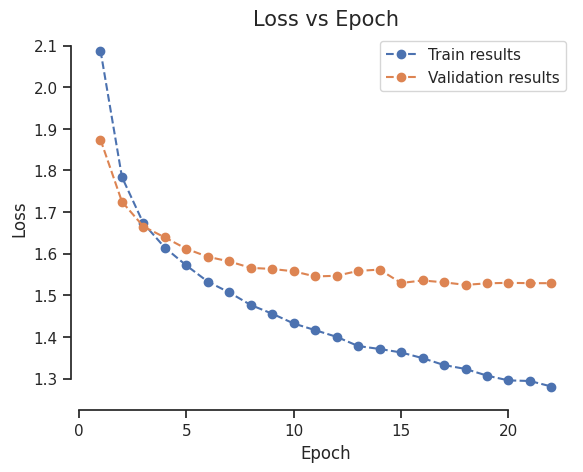

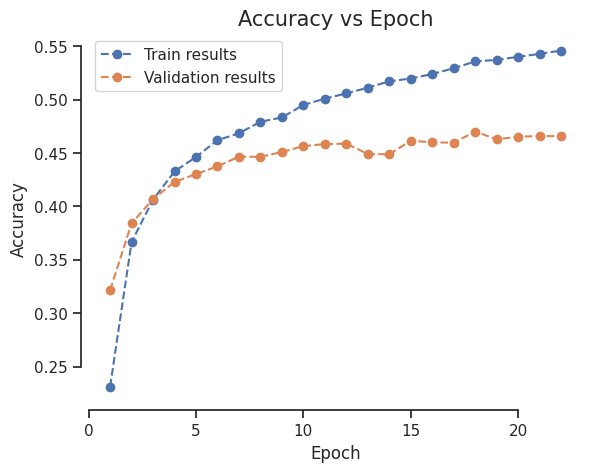

In [61]:
# number of layers

####################
## YOUR CODE HERE ##
####################

img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

learning_rate = 10 ** (-3)

for i in range(1, 6):
    
    early_stopper = EarlyStopper(path = f'early_stoper_checkpoint_num_layers{i}.pt', patience=4)
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=[30] * i, num_hidden_layers=i, act_fn=act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : 4, Number of hidden layers : {i}  ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- In this case, the best validation accuracy achieved was 0.5044 with 180 hidden units after 14 epochs. However, when the model had 2 hidden layers with the number of neurons set lower, the accuracy dropped to 0.4723 after 26 epochs.
- The number of hidden units (neurons) seems to make the largest impact on the model's performance. Increasing the number of neurons improved the validation accuracy. However, it’s important to note that further increasing the number of neurons beyond a certain point led to overfitting, as the model started to perform poorly on new, unseen data.
- No, making a model larger (wider or deeper) doesn't always help. While increasing the size can improve the model's capacity to capture more complex patterns, it can also lead to overfitting—where the model becomes too specialized to the training data and performs poorly on new data. Adding more layers or neurons increases model complexity, and without proper regularization or enough data, it can harm generalization.

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO:
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 178 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 1, Number of hidden units : [30]  ------------------------------------------
Best Validation Accuracy : 0.4639 with Train Accuracy : 0.50275 at Epoch Number : 11
Best Validation Loss : 1.550264310836792 with Train Loss : 1.4036583989858626 at Epoch Number : 13


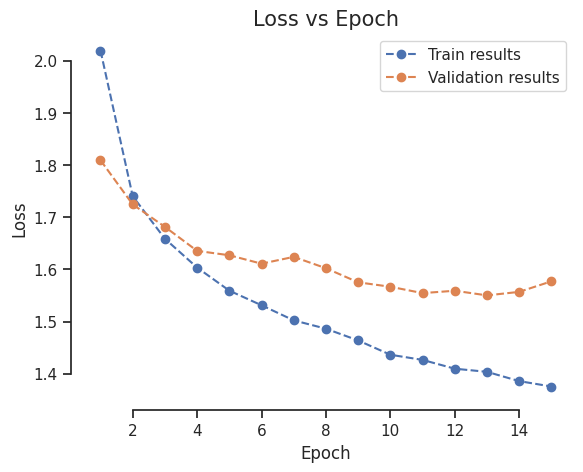

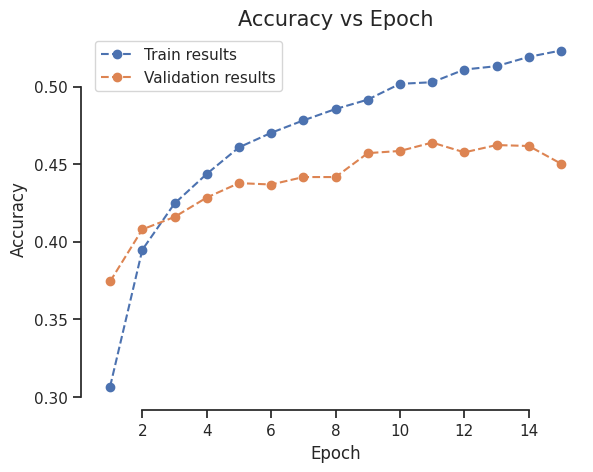

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=40, bias=True), ReLU(), Linear(in_features=40, out_features=10, bias=True)]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3d8211d7e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3d8211d7e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

Early stopping triggered.
Finished training after 225 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 2, Number of hidden units : [50, 40]  ------------------------------------------
Best Validation Accuracy : 0.4847 with Train Accuracy : 0.56475 at Epoch Number : 15
Best Validation Loss : 1.5076680779457092 with Train Loss : 1.2690994322299958 at Epoch Number : 14


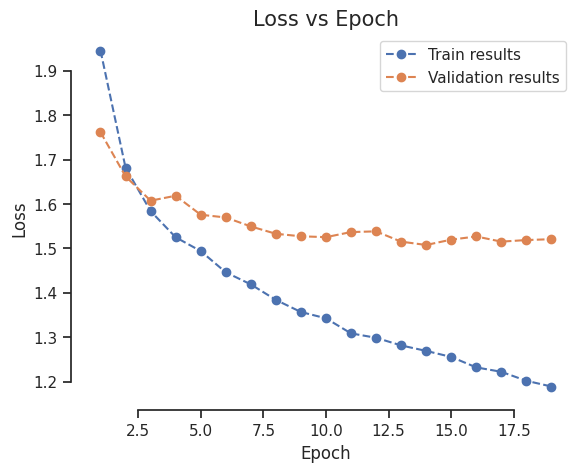

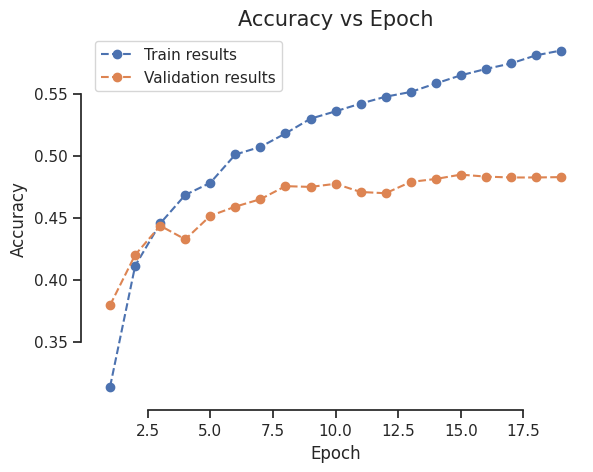

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=30, bias=True), ReLU(), Linear(in_features=30, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 238 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 3, Number of hidden units : [100, 50, 30]  ------------------------------------------
Best Validation Accuracy : 0.4867 with Train Accuracy : 0.612875 at Epoch Number : 16
Best Validation Loss : 1.5118712663650513 with Train Loss : 1.2248831659555435 at Epoch Number : 11


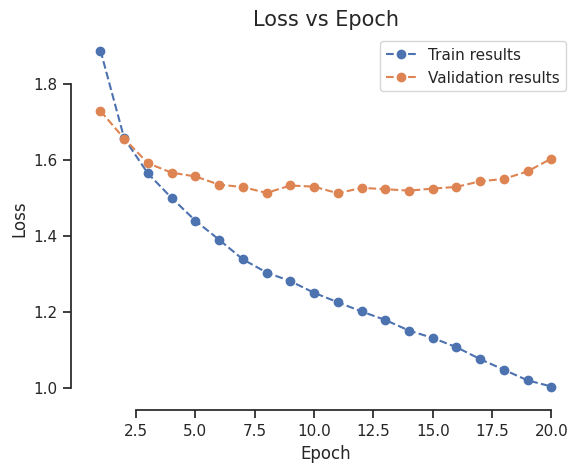

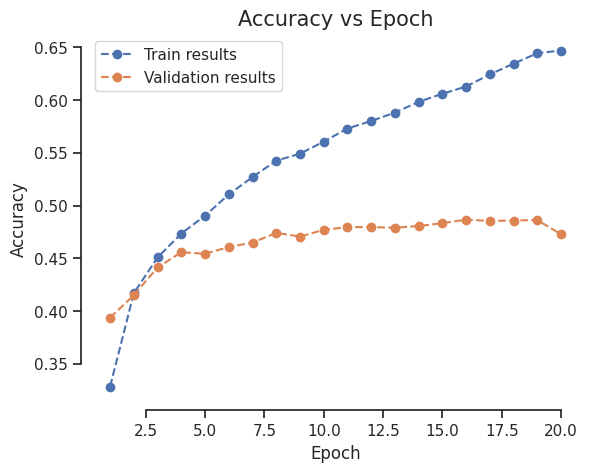

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 267 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 4, Number of hidden units : [128, 64, 32, 16]  ------------------------------------------
Best Validation Accuracy : 0.4963 with Train Accuracy : 0.637925 at Epoch Number : 18
Best Validation Loss : 1.481449592113495 with Train Loss : 1.215445952117443 at Epoch Number : 11


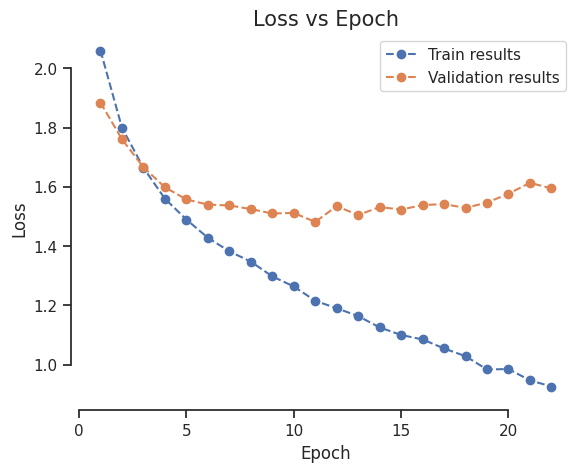

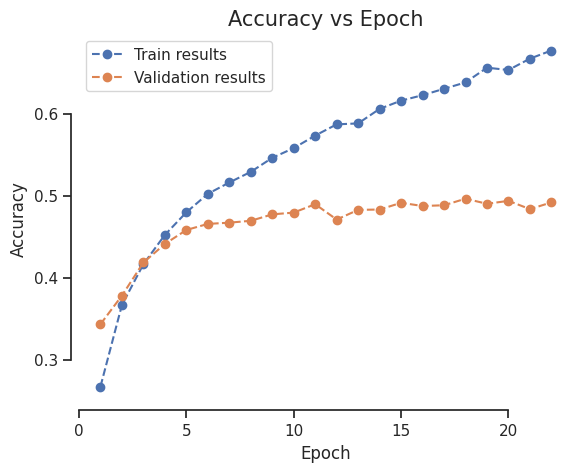

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=256, bias=True), ReLU(), Linear(in_features=256, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=10, bias=True)]


Early stopping triggered.
Finished training after 207 seconds.
------------------------------------------ Learning rate : 0.001, Patience : 4, Number of hidden layers : 5, Number of hidden units : [256, 128, 64, 32, 16]  ------------------------------------------
Best Validation Accuracy : 0.5061 with Train Accuracy : 0.6363 at Epoch Number : 13
Best Validation Loss : 1.4616366505622864 with Train Loss : 1.3177551954984665 at Epoch Number : 7


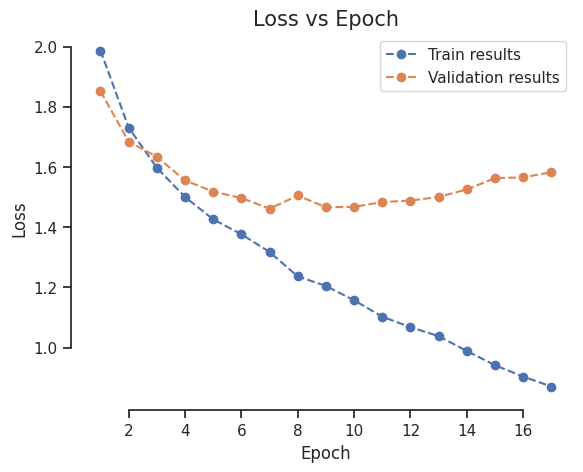

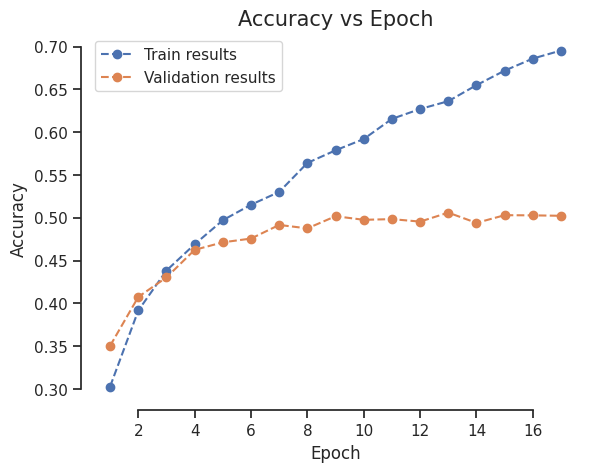

In [63]:
# Your best model:

####################
## YOUR CODE HERE ##
####################

img_height, img_width, num_in_channels = np.asarray(X_sample).shape
num_classes = len(all_labels)

num_hidden_units = 30
num_hidden_layers = 1
act_fn = nn.ReLU()
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

learning_rate = 10 ** (-3)

# List of different configurations for hidden layers and hidden units
hidden_layer_configs = [
    [30],               # 1 hidden layer with 30 units
    [50, 40],           # 2 hidden layers with 50 and 40 units
    [100, 50, 30],      # 3 hidden layers with 100, 50, and 30 units
    [128, 64, 32, 16],  # 4 hidden layers with 128, 64, 32, and 16 units
    [256, 128, 64, 32, 16]  # 5 hidden layers with 256, 128, 64, 32, and 16 units
]

for i, hidden_units in enumerate(hidden_layer_configs, 1):  # i goes from 1 to 5
    num_hidden_layers = len(hidden_units)
    
    early_stopper = EarlyStopper(path = f'early_stoper_checkpoint_num_layers{i}_num_units{hidden_units}.pt', patience=4)
    model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=hidden_units, num_hidden_layers=num_hidden_layers, act_fn=act_fn)
    model.to(device)
    
    model.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(
        model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper = early_stopper
    )
    
    print(f'------------------------------------------ Learning rate : {learning_rate}, Patience : 4, Number of hidden layers : {i}, Number of hidden units : {hidden_units}  ------------------------------------------')
    best_val_acc_index = np.argmax(val_accs)
    print(f'Best Validation Accuracy : {val_accs[best_val_acc_index]} with Train Accuracy : {train_accs[best_val_acc_index]} at Epoch Number : {best_val_acc_index + 1}')
    best_val_loss_index = np.argmin(val_losses)
    print(f'Best Validation Loss : {val_losses[best_val_loss_index]} with Train Loss : {train_losses[best_val_loss_index]} at Epoch Number : {best_val_loss_index + 1}')
    
    plot('Loss vs Epoch', 'Loss', train_losses, val_losses)
    plot('Accuracy vs Epoch', 'Accuracy', train_accs, val_accs)

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

- No, training the same model multiple times from scratch does not guarantee the same performance. This is because neural networks, especially deep ones, are sensitive to initial conditions and can be influenced by factors such as random weight initialization, data shuffling, and random batch selection during training. Therefore the models are not comparable.

- Set a random seed
- Cross-validation
- Multiple runs and averaging
- Statistical testing
- Learning curves
- Hyperparameter search with multiple runs

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO:
- What is the accuracy of the best model you found on the test set?
50.18%
- Plot the confusion matrix, too!

In [71]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    ## YOUR CODE HERE ##
    ####################
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for x, y in test_loader:
            
            y_pred = model(x.to(device))
            correct += sum(y.to(device) == y_pred.argmax(dim=1))
            total += len(y)
            
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1
                
    return accuracy(correct, total), confusion_matrix

*Hint:* Use sklearn to create the confusion matrix ([link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html))

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=3072, out_features=256, bias=True), ReLU(), Linear(in_features=256, out_features=128, bias=True), ReLU(), Linear(in_features=128, out_features=64, bias=True), ReLU(), Linear(in_features=64, out_features=32, bias=True), ReLU(), Linear(in_features=32, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=10, bias=True)]


/tmp/ipykernel_30/4290723207.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_checkpoint_path))


Test Accuracy: 50.18%


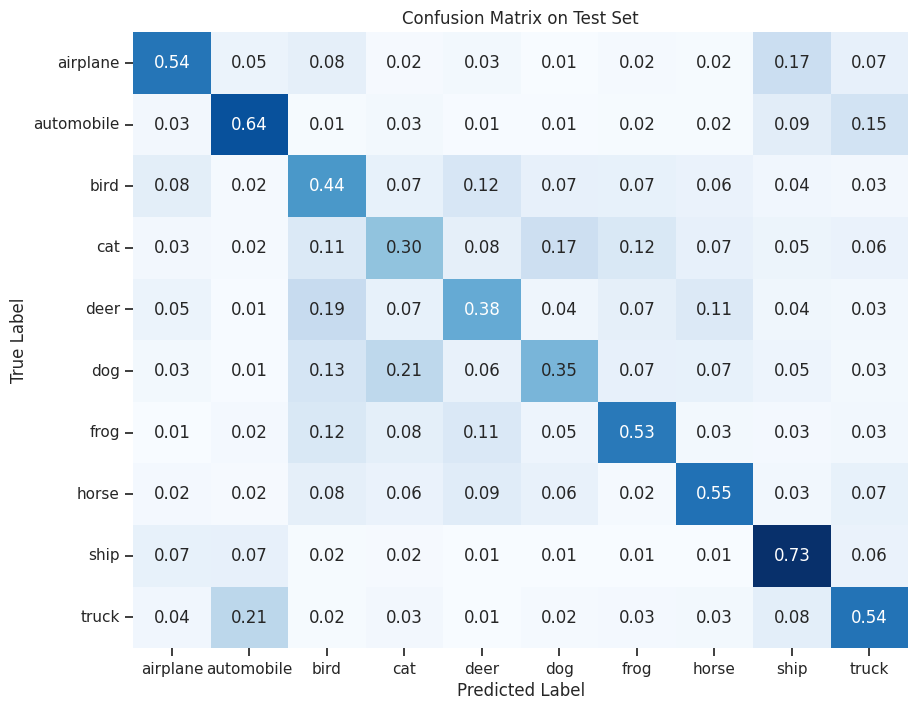

In [75]:
# The accuracy and confusion matrix

####################
## YOUR CODE HERE ##
####################
best_checkpoint_path = 'early_stoper_checkpoint_num_layers5_num_units[256, 128, 64, 32, 16].pt'  # Replace with actual path

best_num_layers = 5
best_hidden_units = [256, 128, 64, 32, 16]

best_model = MLP(img_width, num_in_channels, num_classes, num_hidden_units=best_hidden_units, num_hidden_layers=best_num_layers, act_fn=act_fn)
best_model.to(device)

best_model.load_state_dict(torch.load(best_checkpoint_path))

best_model.eval()
test_accuracy, conf_matrix = test(testloader, best_model, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plotting the confusion matrix
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix = conf_matrix / row_sums
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=all_labels,
            yticklabels=all_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

- Looking at the confusion matrix, we can see that bird, cat, dog, and deer are performing poorly as there are frequent misclassifications in these categories. For example, automobile is classified as truck with probability 0.21. Similarly, cat is classified as dog with the same 0.21 probability.
  
- The test accuracy is 50.18% whereas the validation accuracy is 50.61%. Thus, we can say that the test accuracy is as good as the validation accuracy.

- The difference in the test and validation accuracies can be can be occured due to several reasons:
  1. Overfitting: If the model is overfitting, it performs well on the validation set (which model sees during the training), but poorly on the test set, which contains unseen data.
  2. Dataset Differences: The test set might have different data distributions or characeteristics comparing to training/validation sets.
  3. Data Leakage: If there leakage in the training or validation sets, test set would no longer be unseen.

- We should never use test set performance when trying out different hyper-parameters and architectures because:
  - if you use the test set to optimize hyper-parameters, you are indirectly fitting the model to the test data. This means the model is no longer unbiased towards the test set, and the performance matrix on the test set no longer reflect how the model performs on truly unseen data.

## How about the optimizer? _(Optional)_

_This task is optional, you do not need to solve it_

Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.

#### TODO *(Optional)*:

- Run training of the same model used above with
    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)
- Compare your training results of all the different optimizer settings from above.
- What is your observation while using different optimizers? What is the respective impact on the model performance?

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

## Explore batch size *(Optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(Optional)*:
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).

In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

## Explore Activation Function _(Optional)_

*This task is optional, you do not need to solve it*

### TODO _(Optional)_:

Let's change activation function used (e.g. see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))
- Run training of the same model used above with a new activation function 
- Compare your training results

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################